# ASSAS Dataloader

## AssasDatafile

Reads the data from one file which contains dataframes for one variable and one channel.

## AssasDataset


In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import itertools

from pathlib import Path
from torch.utils.data import Dataset

class AssasDatafile:

    def __init__(self, filepath):
        
        self.data = pd.read_csv(filepath, sep=' ')
        self.filepath = filepath
        print("read file: %s" % (self.filepath))
        self.run = int(filepath.split('_')[-1].replace('.txt',''))
        
        self.timedata = self.data[self.data.columns[0]]
        self.data.drop(self.data.columns[0], axis=1, inplace=True)
        self.data.drop(self.data.columns[-1], axis=1, inplace=True)

        column_parts = AssasDatafile.split_column(self.data)
        
        self.meshes = set(map(lambda x: x[2], column_parts))
        self.variable = set(map(lambda x: x[0], column_parts))
        self.channel = set(map(lambda x: x[1], column_parts))

    @staticmethod
    def split_column(data):
        column_parts = []
        for column in data.columns:
            parts = column.split('_')
            if len(parts) == 3:
                column_parts.append(parts)
            if len(parts) == 4:
                parts = [parts[0]+"_"+parts[1],parts[2],parts[3]]
                column_parts.append(parts)
            if len(parts) == 5:
                parts = [parts[0]+"_"+parts[1]+"_"+parts[2],parts[3],parts[4]]
                column_parts.append(parts)
        
        return column_parts 
    
    def get_data(self):
        return self.data
    
    def get_run(self):
        return self.run
    
    def get_meta_data(self):
        return self.channel, self.variable, self.meshes
    
    def plot_data_mesh(self, mesh):
        
        name = "%s_%s_mesh%d" % (list(self.variable)[0], list(self.channel)[0], mesh)
        plt.figure(figsize=(12,12))
        plt.plot(self.timedata.to_numpy(), self.data[name].to_numpy(), '-^', label=("%s" % name))
        plt.grid(axis='both')
        plt.ylabel('variable %s, channel %s, delta %1.1f s' % (list(self.variable)[0], list(self.channel)[0], self.timedata[1]))
        plt.xlabel('T [s?]')
        plt.legend(title='mesh%d' % (mesh))
        plt.show()
    
    def plot_data_all(self):
        
        plt.figure(figsize=(12,12))
        
        for i in range(1, 16):
            name = "%s_%s_mesh%d" % (list(self.variable)[0], list(self.channel)[0], i)
            plt.plot(self.timedata.to_numpy(), self.data[name].to_numpy(), '-^', label=("mesh%d" % i))

        plt.grid(axis='both')
        plt.ylabel('variable %s, channel %s, delta %1.1f s' % (list(self.variable)[0], list(self.channel)[0], self.timedata[1]))
        plt.xlabel('T [s?]')
        plt.legend(title='mesh1-15')
        plt.show()

    def plot_data(self):
        
        nrows=4
        ncols=4

        fig, axes = plt.subplots(nrows, ncols, sharex=True, figsize=(18,18))
        
        fig.suptitle('variable: %s, run: %d channel: %s, delta %f' 
                     % (list(self.variable)[0], self.run, list(self.channel)[0], self.timedata[1]), fontsize=20)

        counter = 1
        for i in range(0, nrows):
            for ii in range(0, ncols):
                name = "%s_%s_mesh%d" % (list(self.variable)[0], list(self.channel)[0], counter)
                if counter < 16: 
                    axes[i, ii].plot(self.timedata.to_numpy(), self.data[name].to_numpy())
                    axes[i, ii].title.set_text('mesh%d' % (counter))
                counter += 1

        plt.show()

class AssasDataset(Dataset):

    def __init__(self, root, device, history=10, forecast=1, standardize=False, dtype=torch.float32):
        
        self.history = history
        self.forecast = forecast

        self.filenames, self.data = AssasDataset.build_data(root)
        self.data_dict = AssasDataset.build_dict(self.data)
    
    @staticmethod
    def build_data(root):

        filenames = []
        data = []
        for path in Path(root).rglob('*.txt'):
            
            assas_datafile = AssasDatafile(str(path))
            data.append((assas_datafile, list(assas_datafile.variable)[0], list(assas_datafile.channel)[0], assas_datafile.run))
            filenames.append(str(path))

        return filenames, data

    @staticmethod
    def plot_data_dict(data_dict, run, variable, channel):
        
        nrows=4
        ncols=4

        fig, axes = plt.subplots(nrows, ncols, sharex=True, figsize=(18,18))
        
        fig.suptitle('variable: %s, run: %d channel: %s' 
                     % (variable, run, channel), fontsize=20)

        counter = 1
        for i in range(0, nrows):
            for ii in range(0, ncols):
                if counter < 16:
                    meshname = "mesh%d" % (counter)
                    axes[i, ii].plot(data_dict[run][variable][channel]['timedata'], data_dict[run][variable][channel][meshname], '-o')
                    axes[i, ii].title.set_text('mesh%d' % (counter))
                counter += 1

        plt.show()

    @staticmethod
    def build_dict(data):
        
        data_dict = {}
        
        variables = list(set([t[1] for t in data]))
        channels = list(set([t[2] for t in data]))
        runs = list(set([t[3] for t in data]))
        meshes = range(1, 16)

        for run in runs:
            data_dict[run] = {}
            for variable in variables:
                data_dict[run][variable] = {}
                for channel in channels:
                    data_dict[run][variable][channel] = {}
                    data_dict[run][variable][channel]['timedata'] = []
                    for i in meshes:
                        data_dict[run][variable][channel][i] = []                        

        for i in data:
            dataframe = i[0].get_data()
            data_dict[i[3]][i[1]][i[2]]["timedata"] = i[0].timedata.to_numpy()
            for ii in meshes:
                name = "%s_%s_mesh%d" % (i[1], i[2], ii)
                print(name)
                meshname = "mesh%d" % (ii)
                data_dict[i[3]][i[1]][i[2]][meshname] = dataframe[name].to_numpy()

        return data_dict

    def get_data(self):
        return self.data



In [97]:
ad = AssasDataset("./data", "cpu")
ad.data_dict[1]["Debris"]["Ch1"]


read file: data/th_data/CHANNEL2_sat_temp/CHANNEL2_sat_temp_25.txt
read file: data/th_data/CHANNEL2_sat_temp/CHANNEL2_sat_temp_215.txt
read file: data/th_data/CHANNEL2_sat_temp/CHANNEL2_sat_temp_284.txt
read file: data/th_data/CHANNEL2_sat_temp/CHANNEL2_sat_temp_92.txt
read file: data/th_data/CHANNEL2_sat_temp/CHANNEL2_sat_temp_207.txt
read file: data/th_data/CHANNEL2_sat_temp/CHANNEL2_sat_temp_46.txt
read file: data/th_data/CHANNEL2_sat_temp/CHANNEL2_sat_temp_160.txt
read file: data/th_data/CHANNEL2_sat_temp/CHANNEL2_sat_temp_196.txt
read file: data/th_data/CHANNEL2_sat_temp/CHANNEL2_sat_temp_91.txt
read file: data/th_data/CHANNEL2_sat_temp/CHANNEL2_sat_temp_229.txt
read file: data/th_data/CHANNEL2_sat_temp/CHANNEL2_sat_temp_11.txt
read file: data/th_data/CHANNEL2_sat_temp/CHANNEL2_sat_temp_225.txt
read file: data/th_data/CHANNEL2_sat_temp/CHANNEL2_sat_temp_68.txt
read file: data/th_data/CHANNEL2_sat_temp/CHANNEL2_sat_temp_183.txt
read file: data/th_data/CHANNEL2_sat_temp/CHANNEL2_sat

{'timedata': array([    0.        ,    50.0004    ,   100.0004    ,   150.24050341,
          200.4200392 ,   255.3043625 ,   305.3043625 ,   355.3043625 ,
          405.3043625 ,   455.3043625 ,   505.3043625 ,   555.3043625 ,
          605.3043625 ,   655.9293625 ,   705.9293625 ,   755.9293625 ,
          805.9293625 ,   855.9293625 ,   905.9293625 ,   955.9293625 ,
         1005.9293625 ,  1055.9293625 ,  1105.9293625 ,  1155.9293625 ,
         1205.9293625 ,  1255.9293625 ,  1305.9293625 ,  1355.9293625 ,
         1405.9293625 ,  1455.9293625 ,  1505.9293625 ,  1555.9293625 ,
         1605.9293625 ,  1655.9293625 ,  1705.9293625 ,  1755.9293625 ,
         1805.9293625 ,  1855.9293625 ,  1905.9293625 ,  1955.9293625 ,
         2005.9293625 ,  2055.9293625 ,  2105.9293625 ,  2155.9293625 ,
         2205.9293625 ,  2255.9293625 ,  2305.9293625 ,  2355.9293625 ,
         2405.9293625 ,  2455.9293625 ,  2505.9293625 ,  2555.9293625 ,
         2605.9293625 ,  2655.9293625 ,  2705.929362

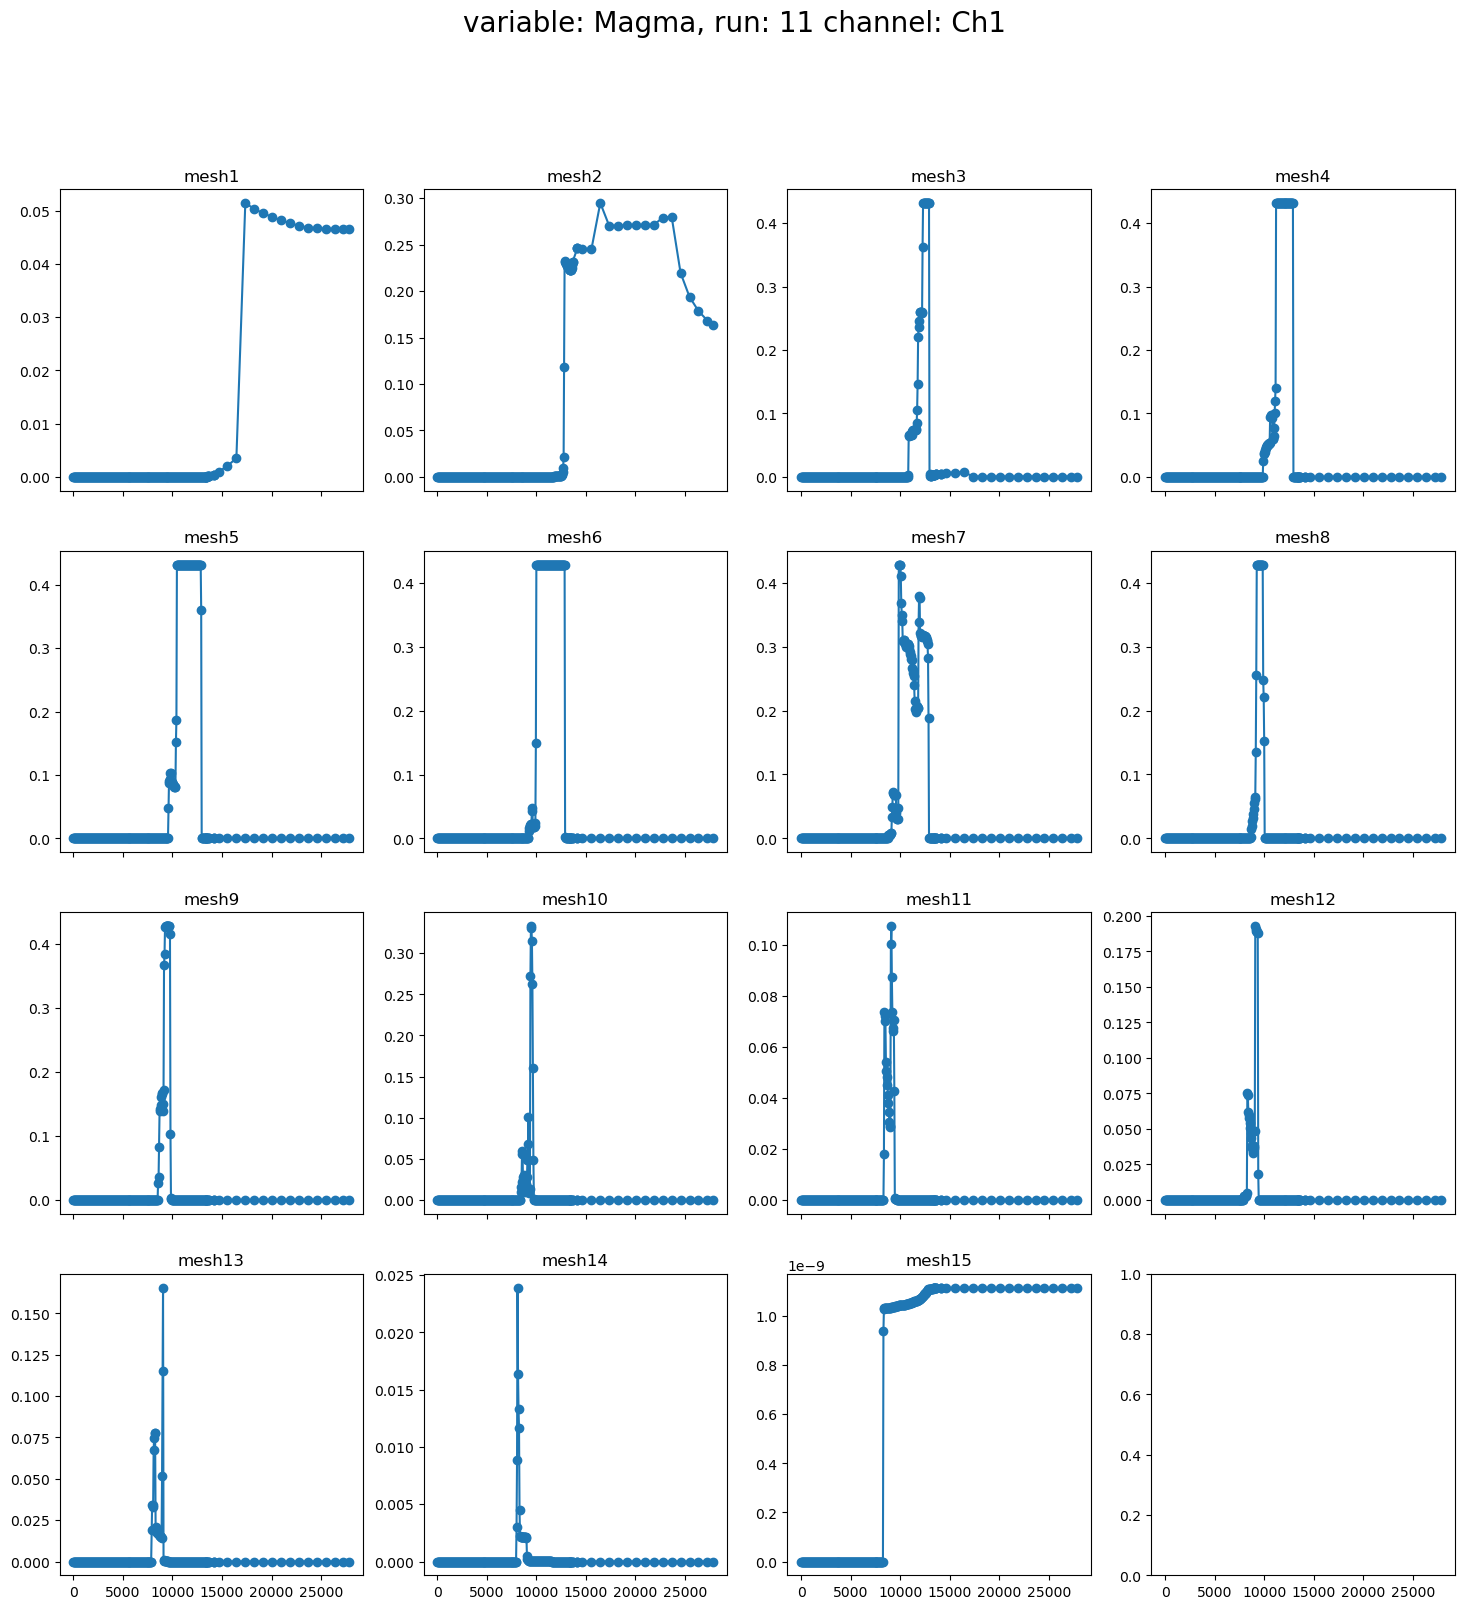

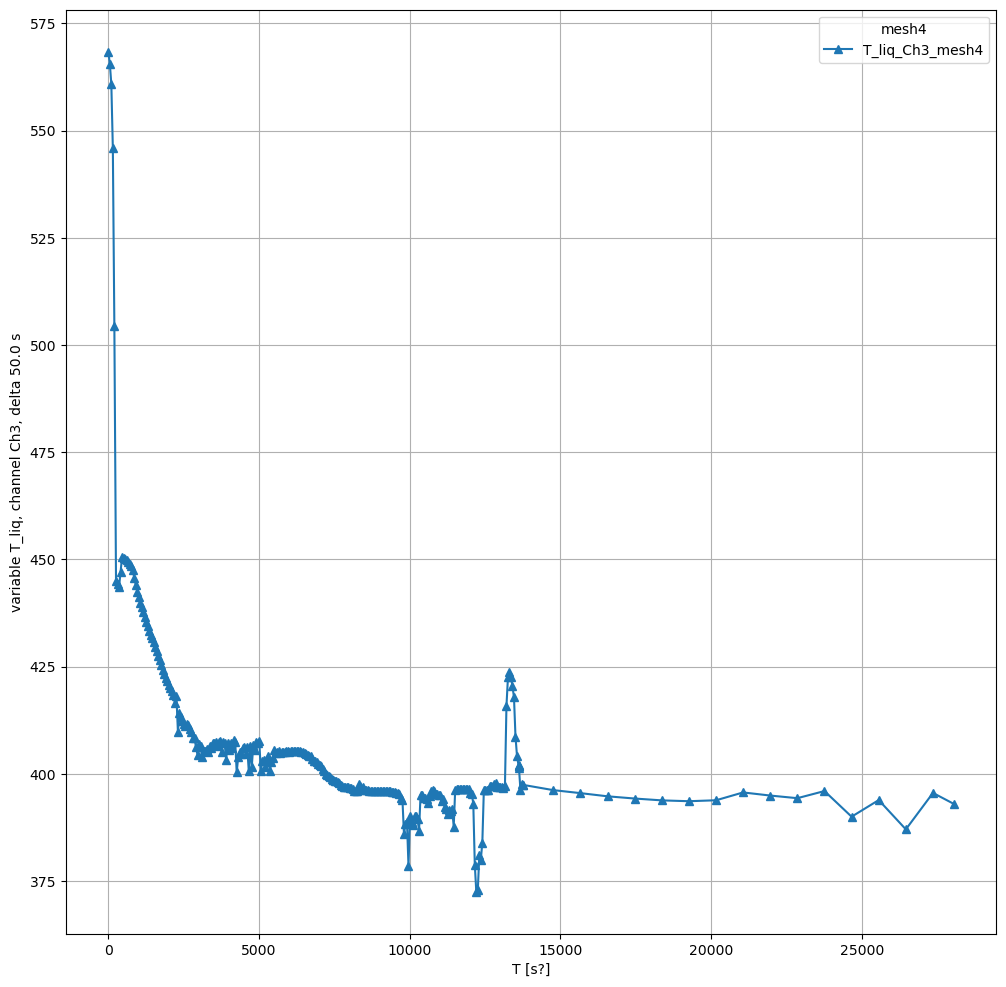

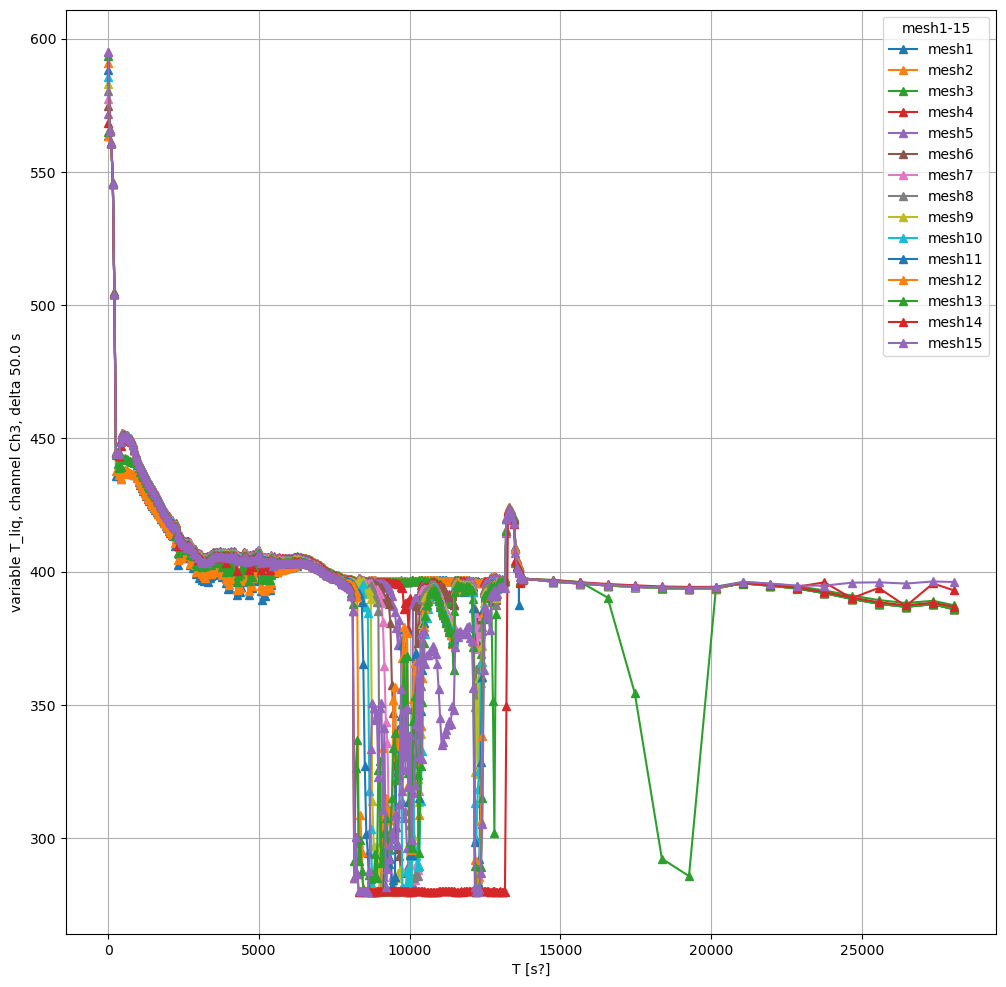

In [98]:
AssasDataset.plot_data_dict(ad.data_dict, 11, "Magma", "Ch1")
ad.data[1000][0].plot_data_mesh(4)
ad.data[1000][0].plot_data_all()

In [84]:
from dash import Dash, dcc, html, Input, Output
from plotly.subplots import make_subplots
import plotly.graph_objects as go

app = Dash(__name__)

runs = list(ad.data_dict.keys())
variables = list(ad.data_dict[runs[1]].keys())
channels = list(ad.data_dict[runs[1]][variables[0]].keys())

app.layout = html.Div([
    html.H4('Live adjustable subplot-width'),
    dcc.Graph(id="graph", style={'width': '1000', 'height': '2000'}),
    html.P("plot for one run and channel"),
    dcc.Slider(
        id='run', min=1, max=300, marks=None,
        value=1, step=1),
    dcc.Slider(
        id='var', min=0, max=5, 
        value=1, step=1, marks={0: variables[0], 1: variables[1], 2: variables[2], 3: variables[3], 4: variables[4], 5: variables[5]}),
    dcc.Slider(
        id='channel', min=0, max=3, 
        value=1, step=1, marks={0: channels[0], 1: channels[1], 2: channels[2], 3: channels[3]})
])

@app.callback(
    Output("graph", "figure"), 
    [Input("run", "value"), 
     Input("var", "value"),
     Input("channel", "value")
     ])
def customize_width(act_run, act_var, act_channel):
    
    fig = make_subplots(rows=4, cols=4)

    fig.add_trace(row=1, col=1,
        trace=go.Scatter(
            x=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["timedata"], 
            y=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["mesh1"]))

    fig.add_trace(row=1, col=2,
        trace=go.Scatter(
            x=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["timedata"], 
            y=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["mesh2"]))
    
    fig.add_trace(row=1, col=3,
        trace=go.Scatter(
            x=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["timedata"], 
            y=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["mesh3"]))

    fig.add_trace(row=1, col=4,
        trace=go.Scatter(
            x=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["timedata"], 
            y=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["mesh4"]))
    
    fig.add_trace(row=2, col=1,
        trace=go.Scatter(
            x=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["timedata"], 
            y=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["mesh5"]))
    
    fig.add_trace(row=2, col=2,
        trace=go.Scatter(
            x=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["timedata"], 
            y=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["mesh6"]))

    fig.add_trace(row=2, col=3,
        trace=go.Scatter(
            x=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["timedata"], 
            y=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["mesh7"]))
    
    fig.add_trace(row=2, col=4,
        trace=go.Scatter(
            x=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["timedata"], 
            y=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["mesh8"]))
    
    fig.add_trace(row=3, col=1,
        trace=go.Scatter(
            x=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["timedata"], 
            y=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["mesh9"]))

    fig.add_trace(row=3, col=2,
        trace=go.Scatter(
            x=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["timedata"], 
            y=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["mesh10"]))
    
    fig.add_trace(row=3, col=3,
        trace=go.Scatter(
            x=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["timedata"], 
            y=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["mesh11"]))

    fig.add_trace(row=3, col=4,
        trace=go.Scatter(
            x=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["timedata"], 
            y=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["mesh12"]))
    
    fig.add_trace(row=4, col=1,
        trace=go.Scatter(
            x=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["timedata"], 
            y=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["mesh13"]))
    
    fig.add_trace(row=4, col=2,
        trace=go.Scatter(
            x=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["timedata"], 
            y=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["mesh14"]))
    
    fig.add_trace(row=4, col=3,
        trace=go.Scatter(
            x=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["timedata"], 
            y=ad.data_dict[act_run][variables[act_var]][channels[act_channel]]["mesh15"]))
    
    fig.update_layout(
    autosize=True,
    width=3000,
    height=3000,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
    )
    
    return fig


app.run_server(debug=True)

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import itertools

from pathlib import Path
from torch.utils.data import Dataset        


variables = ["Debris", "Magma", "q_liq", "P", "T_sat", "T_q_liq", "void"]
channels = ["Ch0", "Ch1", "Ch2", "Ch3"]
meshes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
filenames = ["./data/debris/CHANNEL1/CHANNEL1_DEBRIS_x.txt", 
             "./data/debris/CHANNEL2/CHANNEL2_DEBRIS_x.txt", 
             "./data/debris/CHANNEL3/CHANNEL3_DEBRIS_x.txt", 
             "./data/debris/DOWNCOMER/Downcomer_DEBRIS_x.txt",
             "./data/magma/CHANNEL1/CHANNEL1_MAGMA_x.txt", 
             "./data/magma/CHANNEL2/CHANNEL2_MAGMA_x.txt", 
             "./data/magma/CHANNEL3/CHANNEL3_MAGMA_x.txt", 
             "./data/magma/DOWNCOMER/Downcomer_MAGMA_x.txt",
             "./data/flowrates/CHANNEL_1/CHANNEL1_flowrate_x.txt", 
             "./data/flowrates/CHANNEL_2/CHANNEL2_flowrate_x.txt", 
             "./data/flowrates/CHANNEL_3/CHANNEL3_flowrate_x.txt", 
             "./data/flowrates/Downcomer/Downcomer_flowrate_x.txt",
             "./data/th_data/CHANNEL1_pressure/CHANNEL1_pressure_x.txt", 
             "./data/th_data/CHANNEL2_pressure/CHANNEL2_pressure_x.txt", 
             "./data/th_data/CHANNEL3_pressure/CHANNEL3_pressure_x.txt", 
             "./data/th_data/DOWNCOMER_pressure/Downcomer_pressure_x.txt",
             "./data/th_data/CHANNEL1_sat_temp/CHANNEL1_sat_temp_x.txt", 
             "./data/th_data/CHANNEL2_sat_temp/CHANNEL2_sat_temp_x.txt", 
             "./data/th_data/CHANNEL3_sat_temp/CHANNEL3_sat_temp_x.txt", 
             "./data/th_data/DOWNCOMER_sat_temp/Downcomer_sat_temp_x.txt",
             "./data/th_data/CHANNEL1_temp/CHANNEL1_temp_x.txt", 
             "./data/th_data/CHANNEL2_temp/CHANNEL2_temp_x.txt", 
             "./data/th_data/CHANNEL3_temp/CHANNEL3_temp_x.txt", 
             "./data/th_data/DOWNCOMER_temp/Downcomer_temp_x.txt",
             "./data/th_data/CHANNEL1_void/CHANNEL1_voidf_x.txt", 
             "./data/th_data/CHANNEL2_void/CHANNEL2_voidf_x.txt", 
             "./data/th_data/CHANNEL3_void/CHANNEL3_voidf_x.txt", 
             "./data/th_data/DOWNCOMER_void/Downcomer_voidf_x.txt"]

class AssasDataPlot:

    def __init__(self, filenames):
        
        self.data = self.read_all_runs(filenames)
            
    @staticmethod
    def read_run(run, filenames):

        newfilenames = [""]*len(filenames)
        for i in range(0,len(filenames)):  
            newfilenames[i] = filenames[i].replace("x.txt", "%d.txt" % run)
                    
        file_index = 0
        data = pd.DataFrame()

        for file in newfilenames:    
            
            print("read file %s" % (file))
            dataframe = pd.read_csv(file, sep=' ')

            print("read data of shape (%d,%d)" % (dataframe.shape[0], dataframe.shape[1]))
            
            if file_index > 0:
                dataframe = dataframe.drop('TIME', axis=1)

            print("add column run %d" % (run))
            data["run"] = [run]*dataframe.shape[0]

            data = pd.concat([data, dataframe], axis='columns')
        
            file_index += 1
            
        return data
    
    def get_data(self):
        return self.data

    def read_all_runs(self, filenames, runs=300):
        
        data = pd.DataFrame()
        
        for i in range(1, runs):

            dataframe = self.read_run(i, filenames)
            data = pd.concat([data, dataframe])
            
        return data

    def plot_channel(data, variable, channel):
        
        nrows=4
        ncols=4

        fig, axes = plt.subplots(nrows, ncols, sharex=True, figsize=(18,18))

        fig.suptitle('variable: %s, channel: %s' % (variable, channel), fontsize=20)

        counter = 1
        for i in range(0, nrows):
            for ii in range(0, ncols):
                name = "%s_%s_mesh%d" % (variable, channel, counter)
                if counter < 16: data.plot(x=['TIME'], y=[name], kind="scatter", ax=axes[i, ii])
                counter += 1

        plt.show()

    @staticmethod
    def plot_channel_run(data, variable, channel, run):
        
        nrows=4
        ncols=4

        fig, axes = plt.subplots(nrows, ncols, sharex=True, figsize=(18,18))

        fig.suptitle('variable: %s, run: %d channel: %s' % (variable, run, channel), fontsize=20)

        selected = data[data["run"] == run]

        counter = 1
        for i in range(0, nrows):
            for ii in range(0, ncols):
                name = "%s_%s_mesh%d" % (variable, channel, counter)
                if counter < 16: selected.plot(x=['TIME'], y=[name], kind="scatter", ax=axes[i, ii])
                counter += 1

        plt.show()

In [86]:
data_first_run = AssasDataPlot.read_run(1, filenames)
display(data_first_run)
np.shape(data_first_run)

read file ./data/debris/CHANNEL1/CHANNEL1_DEBRIS_1.txt
read data of shape (272,17)
add column run 1
read file ./data/debris/CHANNEL2/CHANNEL2_DEBRIS_1.txt
read data of shape (272,17)
add column run 1
read file ./data/debris/CHANNEL3/CHANNEL3_DEBRIS_1.txt
read data of shape (272,17)
add column run 1
read file ./data/debris/DOWNCOMER/Downcomer_DEBRIS_1.txt
read data of shape (272,17)
add column run 1
read file ./data/magma/CHANNEL1/CHANNEL1_MAGMA_1.txt
read data of shape (272,17)
add column run 1
read file ./data/magma/CHANNEL2/CHANNEL2_MAGMA_1.txt
read data of shape (272,17)
add column run 1
read file ./data/magma/CHANNEL3/CHANNEL3_MAGMA_1.txt
read data of shape (272,17)
add column run 1
read file ./data/magma/DOWNCOMER/Downcomer_MAGMA_1.txt
read data of shape (272,17)
add column run 1
read file ./data/flowrates/CHANNEL_1/CHANNEL1_flowrate_1.txt
read data of shape (272,17)
add column run 1
read file ./data/flowrates/CHANNEL_2/CHANNEL2_flowrate_1.txt
read data of shape (272,17)
add colum

run          TIME  Debris_Ch1_mesh1  Debris_Ch1_mesh2  Debris_Ch1_mesh3  \
0      1      0.000000               0.0      0.000000e+00               0.0   
1      1     50.000400               0.0      0.000000e+00               0.0   
2      1    100.000400               0.0      0.000000e+00               0.0   
3      1    150.240503               0.0      0.000000e+00               0.0   
4      1    200.420039               0.0      0.000000e+00               0.0   
..   ...           ...               ...               ...               ...   
267    1  23390.451436               0.0      2.041331e-09               0.0   
268    1  24290.451436               0.0      2.095178e-09               0.0   
269    1  25190.451436               0.0      0.000000e+00               0.0   
270    1  26090.451436               0.0      0.000000e+00               0.0   
271    1  26470.451436               0.0      0.000000e+00               0.0   

     Debris_Ch1_mesh4  Debris_Ch1_mesh5  Debris_Ch1_mesh6  Debris_Ch1_mesh7  \
0                 0.0               0.0               0.0               0.0   
1                 0.0               0.0               0.0               0.0   
2                 0.0               0.0               0.0               0.0   
3                 0.0               0.0               0.0               0.0   
4                 0.0               0.0               0.0               0.0   
..                ...               ...               ...               ...   
267               0.0               0.0               0.0               0.0   
268               0.0               0.0               0.0               0.0   
269               0.0               0.0               0.0               0.0   
270               0.0               0.0               0.0               0.0   
271               0.0               0.0               0.0               0.0   

     Debris_Ch1_mesh8  ...  void_Ch0_mesh7  void_Ch0_mesh8  void_Ch0_mesh9  \
0                 0.0  ...        0.000010        0.000010        0.000010   
1                 0.0  ...        0.413073        0.419180        0.425509   
2                 0.0  ...        0.153158        0.156451        0.159714   
3                 0.0  ...        0.382922        0.393158        0.402796   
4                 0.0  ...        0.689853        0.697207        0.705655   
..                ...  ...             ...             ...             ...   
267               0.0  ...        0.999996        0.999996        0.999996   
268               0.0  ...        0.999994        0.999994        0.999994   
269               0.0  ...        0.999993        0.999993        0.999993   
270               0.0  ...        0.999993        0.999993        0.999993   
271               0.0  ...        0.999993        0.999993        0.999993   

     void_Ch0_mesh10  void_Ch0_mesh11  void_Ch0_mesh12  void_Ch0_mesh13  \
0           0.000010         0.000010         0.000010         0.000010   
1           0.432072         0.438876         0.445930         0.453239   
2           0.163067         0.166047         0.170497         0.168843   
3           0.412401         0.420009         0.433266         0.424002   
4           0.710069         0.722521         0.715066         0.751462   
..               ...              ...              ...              ...   
267         0.999996         0.999996         0.999996         0.999996   
268         0.999994         0.999994         0.999994         0.999994   
269         0.999993         0.999994         0.999993         0.999993   
270         0.999993         0.999993         0.999993         0.999993   
271         0.999993         0.999993         0.999993         0.999993   

     void_Ch0_mesh14  void_Ch0_mesh15  Unnamed: 16  
0           0.000010         0.000010          NaN  
1           0.460814         0.468348          NaN  
2           0.192416         0.088539          NaN  
3           0.494100         0.191802        

(272, 450)

In [87]:
adp = AssasDataPlot(filenames)
data = adp.get_data()
np.shape(data)

read file ./data/debris/CHANNEL1/CHANNEL1_DEBRIS_1.txt
read data of shape (272,17)
add column run 1
read file ./data/debris/CHANNEL2/CHANNEL2_DEBRIS_1.txt
read data of shape (272,17)
add column run 1
read file ./data/debris/CHANNEL3/CHANNEL3_DEBRIS_1.txt
read data of shape (272,17)
add column run 1
read file ./data/debris/DOWNCOMER/Downcomer_DEBRIS_1.txt
read data of shape (272,17)
add column run 1
read file ./data/magma/CHANNEL1/CHANNEL1_MAGMA_1.txt
read data of shape (272,17)
add column run 1
read file ./data/magma/CHANNEL2/CHANNEL2_MAGMA_1.txt
read data of shape (272,17)
add column run 1
read file ./data/magma/CHANNEL3/CHANNEL3_MAGMA_1.txt
read data of shape (272,17)
add column run 1
read file ./data/magma/DOWNCOMER/Downcomer_MAGMA_1.txt
read data of shape (272,17)
add column run 1
read file ./data/flowrates/CHANNEL_1/CHANNEL1_flowrate_1.txt
read data of shape (272,17)
add column run 1
read file ./data/flowrates/CHANNEL_2/CHANNEL2_flowrate_1.txt
read data of shape (272,17)
add colum

(99810, 450)

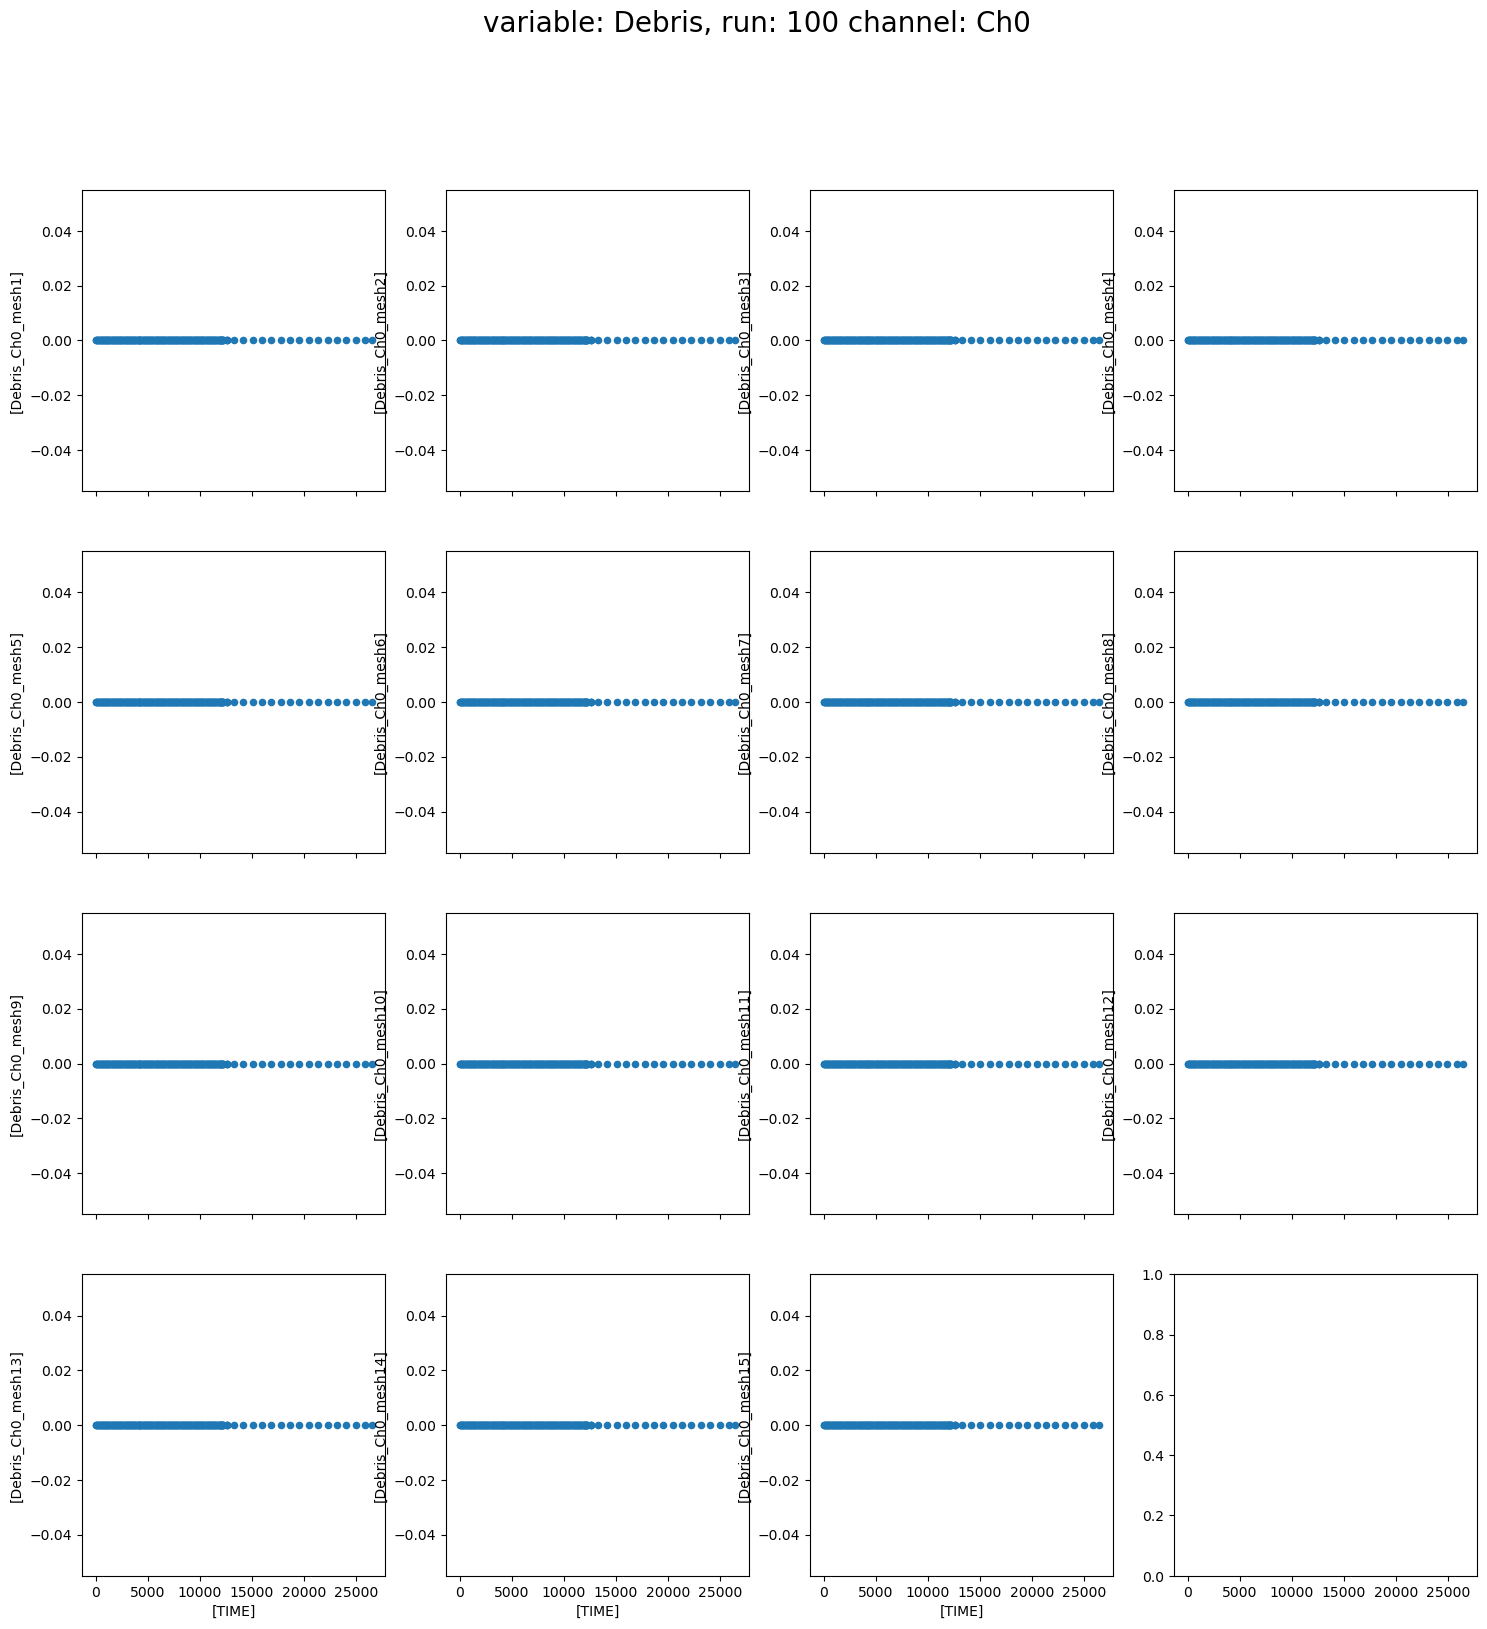

In [88]:
adp.plot_channel_run(data, variables[0], channels[0], 100)

In [89]:
data = AssasDataPlot(filenames).get_data()
np.shape(data)

read file ./data/debris/CHANNEL1/CHANNEL1_DEBRIS_1.txt
read data of shape (272,17)
add column run 1
read file ./data/debris/CHANNEL2/CHANNEL2_DEBRIS_1.txt
read data of shape (272,17)
add column run 1
read file ./data/debris/CHANNEL3/CHANNEL3_DEBRIS_1.txt
read data of shape (272,17)
add column run 1
read file ./data/debris/DOWNCOMER/Downcomer_DEBRIS_1.txt
read data of shape (272,17)
add column run 1
read file ./data/magma/CHANNEL1/CHANNEL1_MAGMA_1.txt
read data of shape (272,17)
add column run 1
read file ./data/magma/CHANNEL2/CHANNEL2_MAGMA_1.txt
read data of shape (272,17)
add column run 1
read file ./data/magma/CHANNEL3/CHANNEL3_MAGMA_1.txt
read data of shape (272,17)
add column run 1
read file ./data/magma/DOWNCOMER/Downcomer_MAGMA_1.txt
read data of shape (272,17)
add column run 1
read file ./data/flowrates/CHANNEL_1/CHANNEL1_flowrate_1.txt
read data of shape (272,17)
add column run 1
read file ./data/flowrates/CHANNEL_2/CHANNEL2_flowrate_1.txt
read data of shape (272,17)
add colum

(99810, 450)

In [90]:
display(data)
selected = data[data["run"] == 1]
display(selected)

run          TIME  Debris_Ch1_mesh1  Debris_Ch1_mesh2  Debris_Ch1_mesh3  \
0      1      0.000000               0.0               0.0               0.0   
1      1     50.000400               0.0               0.0               0.0   
2      1    100.000400               0.0               0.0               0.0   
3      1    150.240503               0.0               0.0               0.0   
4      1    200.420039               0.0               0.0               0.0   
..   ...           ...               ...               ...               ...   
317  299  18972.939813               0.0               0.0               0.0   
318  299  19872.939813               0.0               0.0               0.0   
319  299  20772.939813               0.0               0.0               0.0   
320  299  21672.939813               0.0               0.0               0.0   
321  299  22568.916375               0.0               0.0               0.0   

     Debris_Ch1_mesh4  Debris_Ch1_mesh5  Debris_Ch1_mesh6  Debris_Ch1_mesh7  \
0            0.000000          0.000000          0.000000          0.000000   
1            0.000000          0.000000          0.000000          0.000000   
2            0.000000          0.000000          0.000000          0.000000   
3            0.000000          0.000000          0.000000          0.000000   
4            0.000000          0.000000          0.000000          0.000000   
..                ...               ...               ...               ...   
317          0.000011          0.000016          0.000008          0.000006   
318          0.000011          0.000016          0.000008          0.000016   
319          0.000011          0.000016          0.000008          0.000016   
320          0.000011          0.000016          0.000008          0.000016   
321          0.000013          0.000011          0.000014          0.000001   

     Debris_Ch1_mesh8  ...  void_Ch0_mesh7  void_Ch0_mesh8  void_Ch0_mesh9  \
0            0.000000  ...        0.000010        0.000010        0.000010   
1            0.000000  ...        0.413073        0.419180        0.425509   
2            0.000000  ...        0.153158        0.156451        0.159714   
3            0.000000  ...        0.382922        0.393158        0.402796   
4            0.000000  ...        0.689853        0.697207        0.705655   
..                ...  ...             ...             ...             ...   
317          0.000032  ...        0.999985        0.999985        0.999985   
318          0.000022  ...        0.999986        0.999986        0.999986   
319          0.000022  ...        0.999991        0.999991        0.999991   
320          0.000022  ...        0.999991        0.999990        0.999990   
321          0.000014  ...        0.999992        0.999991        0.999990   

     void_Ch0_mesh10  void_Ch0_mesh11  void_Ch0_mesh12  void_Ch0_mesh13  \
0           0.000010         0.000010         0.000010         0.000010   
1           0.432072         0.438876         0.445930         0.453239   
2           0.163067         0.166047         0.170497         0.168843   
3           0.412401         0.420009         0.433266         0.424002   
4           0.710069         0.722521         0.715066         0.751462   
..               ...              ...              ...              ...   
317         0.999984         0.999973         0.999974         0.999974   
318         0.999985         0.999975         0.999975         0.999976   
319         0.999992         0.999980         0.999976         0.999975   
320         0.999989         0.999978         0.999978         0.999977   
321         0.999987         0.999977         0.999978         0.999977   

     void_Ch0_mesh14  void_Ch0_mesh15  Unnamed: 16  
0           0.000010         0.000010          NaN  
1           0.460814         0.468348          NaN  
2           0.192416         0.088539          NaN  
3           0.494100         0.191802        

run          TIME  Debris_Ch1_mesh1  Debris_Ch1_mesh2  Debris_Ch1_mesh3  \
0      1      0.000000               0.0      0.000000e+00               0.0   
1      1     50.000400               0.0      0.000000e+00               0.0   
2      1    100.000400               0.0      0.000000e+00               0.0   
3      1    150.240503               0.0      0.000000e+00               0.0   
4      1    200.420039               0.0      0.000000e+00               0.0   
..   ...           ...               ...               ...               ...   
267    1  23390.451436               0.0      2.041331e-09               0.0   
268    1  24290.451436               0.0      2.095178e-09               0.0   
269    1  25190.451436               0.0      0.000000e+00               0.0   
270    1  26090.451436               0.0      0.000000e+00               0.0   
271    1  26470.451436               0.0      0.000000e+00               0.0   

     Debris_Ch1_mesh4  Debris_Ch1_mesh5  Debris_Ch1_mesh6  Debris_Ch1_mesh7  \
0                 0.0               0.0               0.0               0.0   
1                 0.0               0.0               0.0               0.0   
2                 0.0               0.0               0.0               0.0   
3                 0.0               0.0               0.0               0.0   
4                 0.0               0.0               0.0               0.0   
..                ...               ...               ...               ...   
267               0.0               0.0               0.0               0.0   
268               0.0               0.0               0.0               0.0   
269               0.0               0.0               0.0               0.0   
270               0.0               0.0               0.0               0.0   
271               0.0               0.0               0.0               0.0   

     Debris_Ch1_mesh8  ...  void_Ch0_mesh7  void_Ch0_mesh8  void_Ch0_mesh9  \
0                 0.0  ...        0.000010        0.000010        0.000010   
1                 0.0  ...        0.413073        0.419180        0.425509   
2                 0.0  ...        0.153158        0.156451        0.159714   
3                 0.0  ...        0.382922        0.393158        0.402796   
4                 0.0  ...        0.689853        0.697207        0.705655   
..                ...  ...             ...             ...             ...   
267               0.0  ...        0.999996        0.999996        0.999996   
268               0.0  ...        0.999994        0.999994        0.999994   
269               0.0  ...        0.999993        0.999993        0.999993   
270               0.0  ...        0.999993        0.999993        0.999993   
271               0.0  ...        0.999993        0.999993        0.999993   

     void_Ch0_mesh10  void_Ch0_mesh11  void_Ch0_mesh12  void_Ch0_mesh13  \
0           0.000010         0.000010         0.000010         0.000010   
1           0.432072         0.438876         0.445930         0.453239   
2           0.163067         0.166047         0.170497         0.168843   
3           0.412401         0.420009         0.433266         0.424002   
4           0.710069         0.722521         0.715066         0.751462   
..               ...              ...              ...              ...   
267         0.999996         0.999996         0.999996         0.999996   
268         0.999994         0.999994         0.999994         0.999994   
269         0.999993         0.999994         0.999993         0.999993   
270         0.999993         0.999993         0.999993         0.999993   
271         0.999993         0.999993         0.999993         0.999993   

     void_Ch0_mesh14  void_Ch0_mesh15  Unnamed: 16  
0           0.000010         0.000010          NaN  
1           0.460814         0.468348          NaN  
2           0.192416         0.088539          NaN  
3           0.494100         0.191802        

In [91]:
adp = AssasDataPlot(filenames)
datad = adp.get_data()

read file ./data/debris/CHANNEL1/CHANNEL1_DEBRIS_1.txt
read data of shape (272,17)
add column run 1
read file ./data/debris/CHANNEL2/CHANNEL2_DEBRIS_1.txt
read data of shape (272,17)
add column run 1
read file ./data/debris/CHANNEL3/CHANNEL3_DEBRIS_1.txt
read data of shape (272,17)
add column run 1
read file ./data/debris/DOWNCOMER/Downcomer_DEBRIS_1.txt
read data of shape (272,17)
add column run 1
read file ./data/magma/CHANNEL1/CHANNEL1_MAGMA_1.txt
read data of shape (272,17)
add column run 1
read file ./data/magma/CHANNEL2/CHANNEL2_MAGMA_1.txt


read data of shape (272,17)
add column run 1
read file ./data/magma/CHANNEL3/CHANNEL3_MAGMA_1.txt
read data of shape (272,17)
add column run 1
read file ./data/magma/DOWNCOMER/Downcomer_MAGMA_1.txt
read data of shape (272,17)
add column run 1
read file ./data/flowrates/CHANNEL_1/CHANNEL1_flowrate_1.txt
read data of shape (272,17)
add column run 1
read file ./data/flowrates/CHANNEL_2/CHANNEL2_flowrate_1.txt
read data of shape (272,17)
add column run 1
read file ./data/flowrates/CHANNEL_3/CHANNEL3_flowrate_1.txt
read data of shape (272,17)
add column run 1
read file ./data/flowrates/Downcomer/Downcomer_flowrate_1.txt
read data of shape (272,17)
add column run 1
read file ./data/th_data/CHANNEL1_pressure/CHANNEL1_pressure_1.txt
read data of shape (272,17)
add column run 1
read file ./data/th_data/CHANNEL2_pressure/CHANNEL2_pressure_1.txt
read data of shape (272,17)
add column run 1
read file ./data/th_data/CHANNEL3_pressure/CHANNEL3_pressure_1.txt
read data of shape (272,17)
add column ru

In [92]:
from dash import Dash, dcc, html, Input, Output
from plotly.subplots import make_subplots
import plotly.graph_objects as go

app = Dash(__name__)

app.layout = html.Div([
    html.H4('Live adjustable subplot-width'),
    dcc.Graph(id="graph", style={'width': '1000', 'height': '2000'}),
    html.P("plot for one run and channel"),
    dcc.Slider(
        id='run', min=1, max=300, marks=None,
        value=1, step=1),
    dcc.Slider(
        id='var', min=0, max=5, 
        value=1, step=1, marks={0: variables[0], 1: variables[1], 2: variables[2], 3: variables[3], 4: variables[4], 5: variables[5]}),
    dcc.Slider(
        id='channel', min=0, max=3, 
        value=1, step=1)
])

@app.callback(
    Output("graph", "figure"), 
    [Input("run", "value"), 
     Input("var", "value"),
     Input("channel", "value")
     ])
def customize_width(act_run, act_var, channel_var):
    
    selected = datad[datad["run"] == act_run]
    
    fig = make_subplots(rows=4, cols=4)

    name = "%s_%s_mesh%d" % (variables[act_var], channels[channel_var], 1)
    fig.add_trace(row=1, col=1,
        trace=go.Scatter(x=selected["TIME"], y=selected[name]))

    name = "%s_%s_mesh%d" % (variables[act_var], channels[channel_var], 1)
    fig.add_trace(row=1, col=2,
        trace=go.Scatter(x=selected["TIME"], y=selected[name]))
    
    name = "%s_%s_mesh%d" % (variables[act_var], channels[channel_var], 3)
    fig.add_trace(row=1, col=3,
        trace=go.Scatter(x=selected["TIME"], y=selected[name]))
    
    name = "%s_%s_mesh%d" % (variables[act_var], channels[channel_var], 4)
    fig.add_trace(row=1, col=4,
        trace=go.Scatter(x=selected["TIME"], y=selected[name]))
    
    name = "%s_%s_mesh%d" % (variables[act_var], channels[channel_var], 5)
    fig.add_trace(row=2, col=1,
        trace=go.Scatter(x=selected["TIME"], y=selected[name]))
    
    name = "%s_%s_mesh%d" % (variables[act_var], channels[channel_var], 6)
    fig.add_trace(row=2, col=2,
        trace=go.Scatter(x=selected["TIME"], y=selected[name]))

    name = "%s_%s_mesh%d" % (variables[act_var], channels[channel_var], 7)
    fig.add_trace(row=2, col=3,
        trace=go.Scatter(x=selected["TIME"], y=selected[name]))
    
    name = "%s_%s_mesh%d" % (variables[act_var], channels[channel_var], 8)
    fig.add_trace(row=2, col=4,
        trace=go.Scatter(x=selected["TIME"], y=selected[name]))
    
    name = "%s_%s_mesh%d" % (variables[act_var], channels[channel_var], 9)
    fig.add_trace(row=3, col=1,
        trace=go.Scatter(x=selected["TIME"], y=selected[name]))
    
    name = "%s_%s_mesh%d" % (variables[act_var], channels[channel_var], 10)
    fig.add_trace(row=3, col=2,
        trace=go.Scatter(x=selected["TIME"], y=selected[name]))
    
    name = "%s_%s_mesh%d" % (variables[act_var], channels[channel_var], 11)
    fig.add_trace(row=3, col=3,
        trace=go.Scatter(x=selected["TIME"], y=selected[name]))

    name = "%s_%s_mesh%d" % (variables[act_var], channels[channel_var], 12)
    fig.add_trace(row=3, col=4,
        trace=go.Scatter(x=selected["TIME"], y=selected[name]))
    
    name = "%s_%s_mesh%d" % (variables[act_var], channels[channel_var], 13)
    fig.add_trace(row=4, col=1,
        trace=go.Scatter(x=selected["TIME"], y=selected[name]))
    
    name = "%s_%s_mesh%d" % (variables[act_var], channels[channel_var], 14)
    fig.add_trace(row=4, col=2,
        trace=go.Scatter(x=selected["TIME"], y=selected[name]))
    
    name = "%s_%s_mesh%d" % (variables[act_var], channels[channel_var], 15)
    fig.add_trace(row=4, col=3,
        trace=go.Scatter(x=selected["TIME"], y=selected[name]))
    
    fig.update_layout(
    autosize=True,
    width=3000,
    height=3000,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
    )
    
    return fig


app.run_server(debug=True)

In [93]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

variable = "Debris"
channel = "Ch1"
run = 122
nruns = 10
# Create figure
fig = make_subplots(rows=4, cols=4)

# Add traces, one for each slider step
#for run in range(1, 300):

selected = datad[datad["run"] == run]

counter = 1
for i in range(1, 5):
    for ii in range(1, 5):
            
        name = "%s_%s_mesh%d" % (variable, channel, counter)
            
        if counter < 16:
                
            fig.add_trace(
                go.Scatter(
                    x=selected["TIME"],
                    y=selected[name]),
                    row=i,
                    col=ii)
            
        counter+=1

fig.show()

In [94]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

variable = "Debris"
channel = "Ch1"
run = 1
# Create figure
fig = make_subplots(rows=4, cols=4)

# Add traces, one for each slider step
#for run in range(1, 300):

selected = datad[datad["run"] == run]

counter = 1
for i in range(1, 5):
    for ii in range(1, 5):
            
        name = "%s_%s_mesh%d" % (variable, channel, counter)
            
        if counter < 16:
                
            fig.add_trace(
                go.Scatter(
                    x=selected["TIME"],
                    y=selected[name]),
                    row=i,
                    col=ii)
            
        counter+=1

# Make 10th trace visible
#fig.data[10].visible = True

# Create and add slider
runs = []
for i in range(len(fig.data)):
    run = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Show data for run: " + str(i)}],  # layout attribute
    )
    run["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    runs.append(run)

#sliders = [dict(
#    active=1,
#    currentvalue={"prefix": "Frequency: "},
#    pad={"t": 50},
#    steps=runs
#)]

#fig.update_layout(
#    sliders=sliders
#)

fig.show()

In [95]:
import plotly.express as px

df = px.data.gapminder()
fig = px.scatter(df, x="gdpPercap", y="lifeExp", animation_frame="year", animation_group="country",
           size="pop", color="continent", hover_name="country",
           log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90])

fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()